## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Насыбуллин А. А.|
|---------|--------|
| Группа  | М8О-107М-20 VR/AR & ИИ|

Для скачивания датасетов можно Использовать `wget` или `curl`, либо скачать вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

### Подлючение модулей и библиотек

In [31]:
import pickle
import numpy as np
import pandas as pd
import os
from time import time
import pandas as pd

%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import seaborn as sns 

from sklearn.model_selection import train_test_split

Настройка Pandas

In [32]:
# установка максимального количества столбцов и строк для вывода
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

# установка количества знаков после запятой
pd.set_option("precision", 2)

## Классы для работы с нейронной сетью

### Класс нейросети

In [33]:
class NeuralNetwork:
  # конструктор
  def __init__(self, layers: [] = []):
    self.layers = layers
  
  # добавление слоя
  def add(self, layer):
    self.layers.append(layer)
  
  # прямой ход: вычисление результа работы нейросети (проход по всем слоям от первого до последнего)
  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x
  
  # обратное распространение ошибки (проход с последнего слоя к первому)
  def backward(self, z):
    for layer in self.layers[::-1]:
      z = layer.backward(z)
    return z
  
  # обновление весов для слоев, имеющих данный функционал
  def update(self, learning_rate: float):
    for layer in self.layers:
      layer.update(learning_rate)

### Класс слоя нейросети

In [34]:
# класс слоя нейросети
class NeuralNetworkLayer:
  def __init__(self, n_inputs:int, n_outputs: int, activation_func):
    self.activation_func = activation_func
    self.weights = np.random.normal(0, 1.0 / np.sqrt(n_inputs), (n_outputs, n_inputs))
    self.bias = np.zeros((1, n_outputs))
    self.d_weights = np.zeros_like(self.weights)
    self.d_bias = np.zeros_like(self.bias)

  # вычисление результата работы слоя
  def forward(self, x):
    self.x = x
    pred = np.dot(x, self.weights.T)
    pred = pred + self.bias
    outputs = self.activation_func.forward(pred)
    return outputs
  
  # обратное распространение ошибки
  def backward(self, dz):
    dz = self.activation_func.backward(dz)
    dx = np.dot(dz, self.weights)
    d_weights = np.dot(dz.T, self.x)
    d_bias = dz.sum(axis=0)
    self.d_weights = d_weights
    self.d_bias = d_bias
    return dx

  # обновление весов
  def update(self, learning_rate: float):
    self.weights -= learning_rate * self.d_weights
    self.bias -= learning_rate * self.d_bias

### Класс функций активации

In [35]:
class ActivationFunction:
  def __init__(self, func: str='softmax'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, z):
    self.forward(self, z)
  
  # обратное распространение ошибки
  def backward(self, dp):
    self.backward(self, dp)
      
  def __set_forward__(self, func):
    if self.func == 'softmax':
      self.forward = self.__softmax_forward__
    elif self.func == 'tanh':
      self.forward = self.__tanh_forward__
    elif self.func == 'sigmoid':
      self.forward = self.__sigmoid_forward__
    else:
      self.forward = self.__softmax_forward__
        
  def __set_backward__(self, func):
    if self.func == 'softmax':
      self.backward = self.__softmax_backward__
    elif self.func == 'tanh':
      self.backward = self.__tanh_backward__
    elif self.func == 'sigmoid':
      self.backward = self.__sigmoid_backward__
    else:
      self.backward = self.__softmax_backward__

  def __sigmoid_forward__(self, x):
    self.sigmoid_x = x
    a = (1/(1+np.exp(-x)))
    self.sigmoid_a = a
    return a

  def __sigmoid_backward__(self, dy):
    return ((self.sigmoid_a) * (1 - self.sigmoid_a)) * dy

  def __softmax_backward__(self, dp):
    p = self.forward(self.softmax_z)
    pdp = p * dp
    result = pdp - p * pdp.sum(axis=1, keepdims=True)
    return result

  def __softmax_forward__(self, z):
    self.softmax_z = z
    zmax = z.max(axis=1, keepdims=True)
    expz = np.exp(z - zmax)
    Z = expz.sum(axis=1, keepdims=True)
    probabilities = expz / Z
    return probabilities

  def __tanh_forward__(self, z):
    y = np.tanh(z)
    self.tanh_y = y
    return y
  
  def __tanh_backward__(self, dy):
    return (1.0 - self.tanh_y**2) * dy

### Класс функций потерь

In [36]:
class LossFunction:
  def __init__(self, func: str='cross-entropy'):
    self.func = func
    self.__set_forward__(func)
    self.__set_backward__(func)

  # вычисление результата работы слоя
  def forward(self, p, y):
    self.forward(self, p, y)
  
  # обратное распространение ошибки
  def backward(self, loss):
    self.backward(self, loss)
      
  def __set_forward__(self, func):
    if self.func == 'cross-entropy':
      self.forward = self.__cross_entropy_forward__
    else:
      self.forward = self.__cross_entropy_forward__
        
  def __set_backward__(self, func):
    if self.func == 'cross-entropy':
      self.backward = self.__cross_entropy_backward__
    else:
      self.backward = self.__cross_entropy_backward__

  def __cross_entropy_forward__(self, p, y):
    self.p = p
    self.y = y
    p_of_y = p[np.arange(len(y)), y]
    self.log_prob = np.log(p_of_y)
    result = -self.log_prob.mean()
    return result
  
  def __cross_entropy_backward__(self, loss):
    dlog_softmax = np.zeros_like(self.p)
    dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
    result = dlog_softmax / self.p
    return result

### Класс для тренировки нейросети

In [37]:
class NeuralNetworkTrainer:
  def __init__(self, mini_batch_size=4, learning_rate=0.01):
    # self.network = network
    self.mini_batch_size = mini_batch_size;
    self.learning_rate = learning_rate;
  
  # обучение нейронной сети эпохами
  def train_epoch(self, net, x_train, y_train, loss):
    for i in range(0, len(x_train), self.mini_batch_size):
      x_batch = x_train[i:i + self.mini_batch_size]
      y_batch = y_train[i:i + self.mini_batch_size]

      pred = net.forward(x_batch)
      losses = loss.forward(pred, y_batch)
  
      d_pred = loss.backward(losses)
      dx = net.backward(d_pred)
      net.update(self.learning_rate)

  # обучение нейронной сети эпохами
  def train_epoch_by_batches(self, net, x_train, y_train, x_test, y_test, n_epoch, loss, n_batches=5):
    metrics = NeuralNetworkMetrics()
    
    train_accurancy = np.empty((n_epoch + 1, 3))
    train_accurancy[:] = np.NAN
    valid_accurancy = np.empty((n_epoch + 1, 3))
    valid_accurancy[:] = np.NAN
    start_time = time()
    
    train_acc = []
    valid_acc = []
    x_batches = np.split(x_train, n_batches)
    y_batches = np.split(y_train, n_batches)
    for epoch in range(n_epoch + 1):
      if epoch != 0:
        for i in range(n_batches):
          self.train_epoch(net, x_batches[i], y_batches[i], loss)
    
      t_loss, t_accuracy = metrics.get_avg_loss_accurancy(net, x_train, y_train, loss, n_batches)
      train_accurancy[epoch, :] = [epoch, t_loss, t_accuracy]

      v_loss, v_accuracy = metrics.get_avg_loss_accurancy(net, x_test, y_test, loss, n_batches)
      valid_accurancy[epoch, :] = [epoch, v_loss, v_accuracy]
      
      if epoch == 0:
        print(f'Initial train loss={t_loss:.3f}, accuracy={t_accuracy:.3f}')
        print(f'Initial valid loss={v_loss:.3f}, accuracy={v_accuracy:.3f}')
    end_time = time()

    train_time = end_time - start_time

    print(f'Final train loss={train_accurancy[-1, 1]:.3f}, accuracy={train_accurancy[-1, 2]:.3f}')
    print(f'Final valid loss={valid_accurancy[-1, 1]:.3f}, accuracy={valid_accurancy[-1, 2]:.3f}')

    return train_accurancy, valid_accurancy, train_time

### Класс для вычислений метрик работы нейросети

In [38]:
class NeuralNetworkMetrics:
  # получение ошибки и точности предсказания
  def get_avg_loss_accurancy(self, net, x, y, loss, n_batches=5):
    sum_losses = np.zeros((n_batches,))
    sum_accurancy = np.zeros((n_batches,))
    x_batches = np.split(x, n_batches)
    y_batches = np.split(y, n_batches)
    for i in range(n_batches):
      losses, accurancy = self.__get_loss_mean_accurancy__(net, x_batches[i], y_batches[i], loss)
      sum_losses[i] = losses
      sum_accurancy[i] = accurancy
    return sum_losses.mean(), sum_accurancy.mean()


  def __get_loss_mean_accurancy__(self, net, x, y, loss):
    pred = net.forward(x)
    losses = loss.forward(pred, y)
    pred_max = np.argmax(pred, axis=1)
    accurancy = (pred_max == y).mean()
    return losses, accurancy


  def get_predicts(self, net, x, y, loss, n_batches=5):
    predicts = []
    x_batches = np.split(x, n_batches)
    y_batches = np.split(y, n_batches)
    for i in range(n_batches):
      predicts.append(self.__get_predicts__(net, x_batches[i], y_batches[i], loss))
    return predicts


  def __get_predicts__(self, net, x, y, loss):
    pred = net.forward(x)
    losses = loss.forward(pred, y)
    pred_max = np.argmax(pred, axis=1)
    # accurancy = (pred_max == y).mean()
    return pred_max

## Вспомогательные функции

### Функция построения матрицы ошибок

In [39]:
def plot_confusion_matrix(net, x_test, y_test, loss, n_batches, 
                          db_name: str, img_dir: str, img_format: str, description: str):
  y_pred = metrics.get_predicts(net, x_test, y_test, loss, n_batches)
  y_pred =  np.array(y_pred).flatten()

  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

  df_y_test = pd.Series(y_test, name='Actual Class')
  df_y_pred = pd.Series(y_pred, name='Predicted Class')

  df_confusion = pd.crosstab(df_y_test, df_y_pred)
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.heatmap(df_confusion, annot=True, cmap="RdYlGn", linewidths=.5, fmt= '.2f', ax=ax);
  title = f'{db_name}. Confussion Matrix (not normalized)'
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)
  plt.title(title)
  plt.savefig(os.path.join(img_dir, f'{title}{img_format}'), bbox_inches='tight')
  plt.show()

  df_confusion = df_confusion / df_confusion.sum(axis=1)
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.heatmap(df_confusion, annot=True, cmap="RdYlBu", linewidths=.5, fmt= '.2f', ax=ax);
  title = f'{db_name}. Confussion Matrix (normalized)'
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)

  plt.title(title)

  plt.savefig(os.path.join(img_dir, f'{title}{img_format}'), bbox_inches='tight')
  plt.show()

### Функция визуального мониторинга работы нейросети

In [40]:
# обучение и построение графика
def train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch: int, 
                   loss, n_batches, db_name: str, img_dir: str, img_format: str):
  img_name = get_img_name(db_name, len(net.layers), n_epoch, trainer.mini_batch_size, 
                          trainer.learning_rate, loss.func, img_format)

  train_accurancy, valid_accurancy, train_time \
        = trainer.train_epoch_by_batches(net, x_train, y_train, x_test, y_test, 
                                         n_epoch, loss, n_batches)
  x = train_accurancy[:, 0]
  y = (train_accurancy[:, 2], valid_accurancy[:, 2])

  description = f'Database: {db_name}\
  \nLayers: {len(net.layers)}\
  \nActivation Funcs: {[x.activation_func.func for x in net.layers]}\
  \nEpoches: {n_epoch}\
  \nBatches: {n_batches}\
  \nMini Batch Size: {trainer.mini_batch_size}\
  \nLearning Rate: {trainer.learning_rate:.3f}\
  \nLoss Function: {loss.func}\
  \nTrain Time: {train_time:.3f} sec.\
  \nFinal Train Loss: {train_accurancy[-1, 1]:.3f}\
  \nFinal Train Accuracy: {train_accurancy[-1, 2]:.3f}\
  \nFinal Valid Loss: {valid_accurancy[-1, 1]:.3f}\
  \nFinal Valid Accuracy: {valid_accurancy[-1, 2]:.3f}'

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x, y[0], 'k--', label='training accuracy')
  ax.plot(x, y[1], 'g-', label='validation accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Acurancy')
  ax.set_xlabel('Epoches')
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(x=1.2, y=0.5, s=description, transform=ax.transAxes, fontsize=12,
           verticalalignment='bottom', bbox=props)

  title = f'{db_name}. MPL Train and Validation'
  ax.set_title(f'{title}')
  
  if not os.path.isdir(img_dir):
    os.mkdir(img_dir)
  plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
  plt.show()
  return description

### Функция генерции названия картинки

In [41]:
def get_img_name(dataset: str, layers, n_epoch, batch_size, learning_rate, loss_func, format: str):
  return f'DS({dataset})_NL({layers})_E({n_epoch})_B({batch_size})_LR({learning_rate})_LF({loss.func}){format}'

## Установка модулей для загрузки и распаковки данных

In [42]:
!pip install gzip-reader
!pip install rm
!pip install wget

## Fashion MNIST

### Настройка путей для сохранения файлов

In [43]:
if 'google.colab' in str(get_ipython()):
    data_dir = os.path.join(os.getcwd(), '/content/data/fashion-mnist')
else:
    data_dir = os.path.join(os.getcwd(), '../../../data/fashion-mnist')


img_dir = os.path.join(os.getcwd(), 'img_fashion-mnist')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

### Fashion MNIST. Загрузка данных

In [44]:
!wget -P data/fashion-mnist http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -P data/fashion-mnist http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -P data/fashion-mnist http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -P data/fashion-mnist http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-04-28 22:10:29--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.158
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘data/fashion-mnist/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  6.46MB/s    in 3.9s    

2021-04-28 22:10:33 (6.46 MB/s) - ‘data/fashion-mnist/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-04-28 22:10:33--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.234
Connecting to fash

Распаковка данных

In [45]:
!gzip -d /content/data/fashion-mnist/t10k-images-idx3-ubyte.gz
!gzip -d /content/data/fashion-mnist/t10k-labels-idx1-ubyte.gz
!gzip -d /content/data/fashion-mnist/train-images-idx3-ubyte.gz
!gzip -d /content/data/fashion-mnist/train-labels-idx1-ubyte.gz

gzip: /content/data/fashion-mnist/t10k-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? y
gzip: /content/data/fashion-mnist/t10k-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? 
	not overwritten
gzip: /content/data/fashion-mnist/train-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: /content/data/fashion-mnist/train-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten


Установка модуля idx2numpy для получения numpy массивов из распакованных данных

In [46]:
!pip install idx2numpy
import idx2numpy

Разбиваем данные на обучающие и тестовые выборки

In [47]:
x_train = idx2numpy.convert_from_file(os.path.join(data_dir, 'train-images-idx3-ubyte'))
y_train = idx2numpy.convert_from_file(os.path.join(data_dir, 'train-labels-idx1-ubyte'))
x_test = idx2numpy.convert_from_file(os.path.join(data_dir, 't10k-images-idx3-ubyte'))
y_test = idx2numpy.convert_from_file(os.path.join(data_dir, 't10k-labels-idx1-ubyte'))

### Fashion MNIST. Первоначальный анализ данных, предобработка

In [48]:
print(f'Размерность матрицы данных train_images: {x_train.shape}')
print(f'Размерность матрицы данных test_images: {x_test.shape}')
print(f'Размерность матрицы данных train_labels: {y_train.shape}')
print(f'Размерность матрицы данных test_labels: {y_test.shape}')

print(f'Количество признаков (пикселей): {x_train.shape[1]}')
print(f'Количество объектов (картинок): {x_train.shape[0]}')

# необходимо узнать количество классов на выходе
print(f'Количество разных ответов (классов): {len(np.unique(y_train))}')

Размерность матрицы данных train_images: (60000, 28, 28)
Размерность матрицы данных test_images: (10000, 28, 28)
Размерность матрицы данных train_labels: (60000,)
Размерность матрицы данных test_labels: (10000,)
Количество признаков (пикселей): 28
Количество объектов (картинок): 60000
Количество разных ответов (классов): 10


Приводим данные признаков к типу float и масштабируем в диапазон от 0 до 1

In [49]:
x_train = x_train.astype(float)
x_train = x_train / 255

x_test = x_test.astype(float)
x_test = x_test / 255

Преобразуем данные признаков в двумерные матрицы

In [50]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

print(f'Размерность матрицы данных x_train: {x_train.shape}')
print(f'Размерность матрицы данных x_test: {x_test.shape}')

Размерность матрицы данных x_train: (60000, 784)
Размерность матрицы данных x_test: (10000, 784)


### Fashion MNIST. Применение нейронных сетей и отображение графика обучения

In [51]:
loss = LossFunction('cross-entropy')
metrics = NeuralNetworkMetrics()
n_epoch = 30

Применение нейронной сети с одним слоем (с различными гиперпараметрами)

Initial train loss=2.382, accuracy=0.068
Initial valid loss=2.380, accuracy=0.071
Final train loss=0.405, accuracy=0.862
Final valid loss=0.449, accuracy=0.842


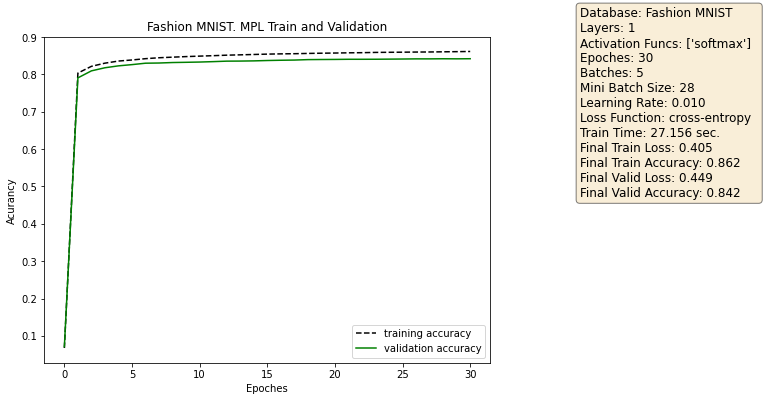

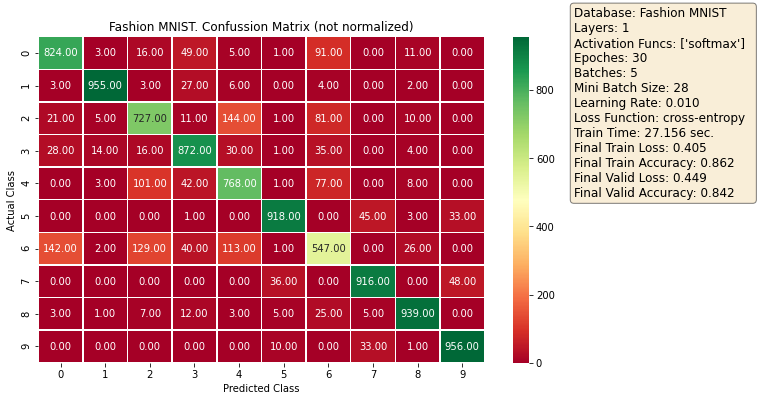

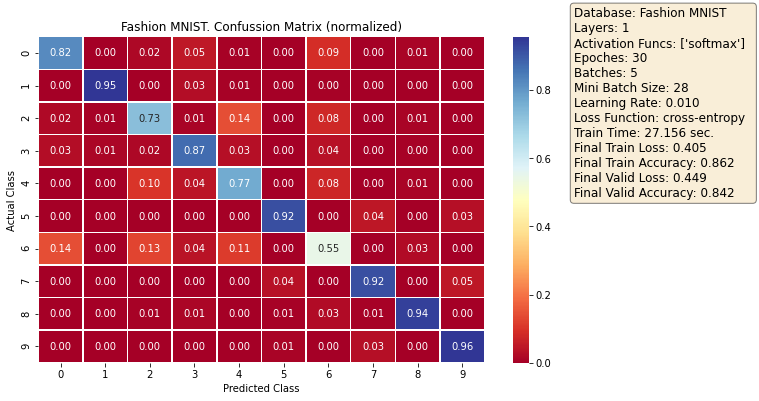

In [52]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l1'), ' 1.png', description)

Initial train loss=2.492, accuracy=0.028
Initial valid loss=2.493, accuracy=0.030
Final train loss=0.386, accuracy=0.864
Final valid loss=0.454, accuracy=0.839


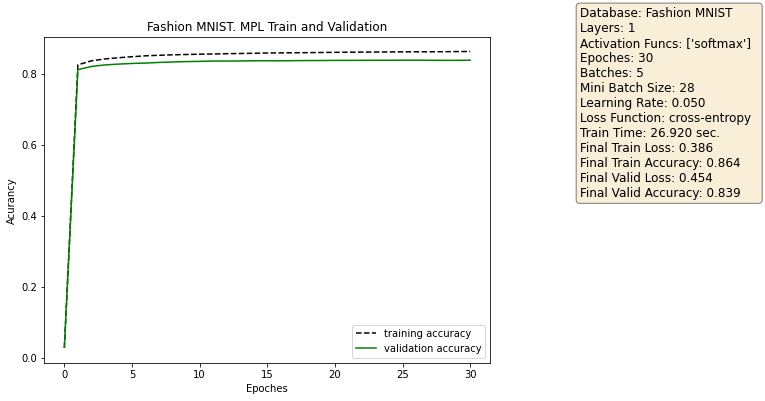

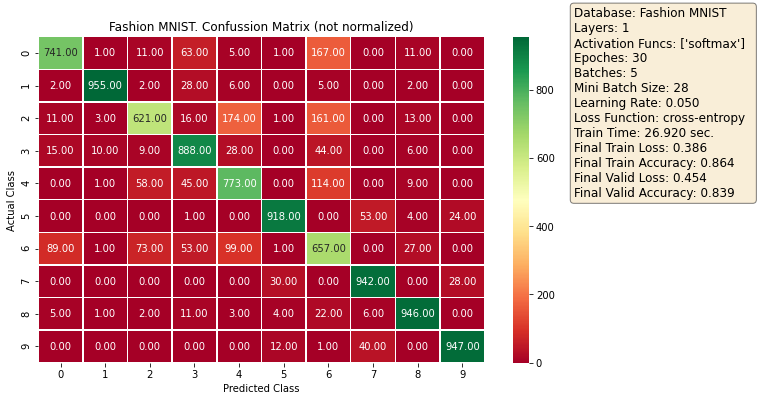

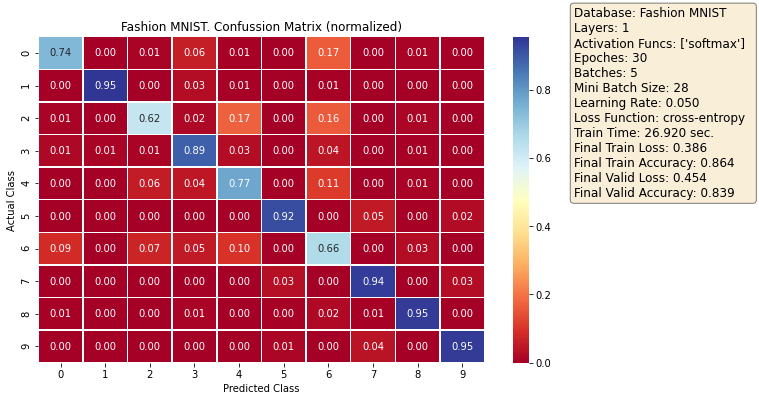

In [53]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.05)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l1'), ' 2.png', description)

Initial train loss=2.377, accuracy=0.109
Initial valid loss=2.380, accuracy=0.109
Final train loss=0.426, accuracy=0.850
Final valid loss=0.512, accuracy=0.823


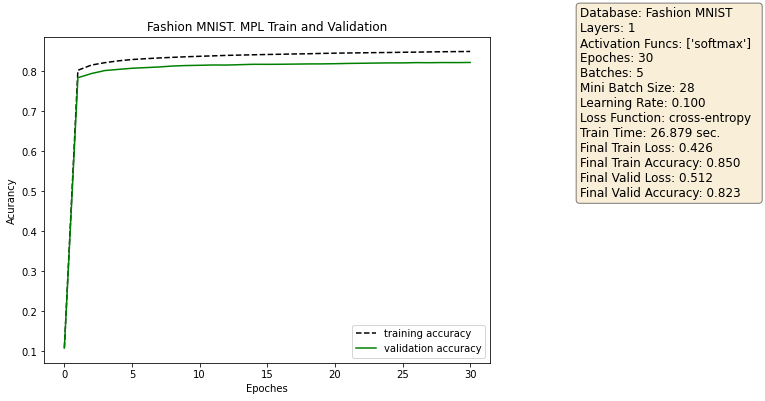

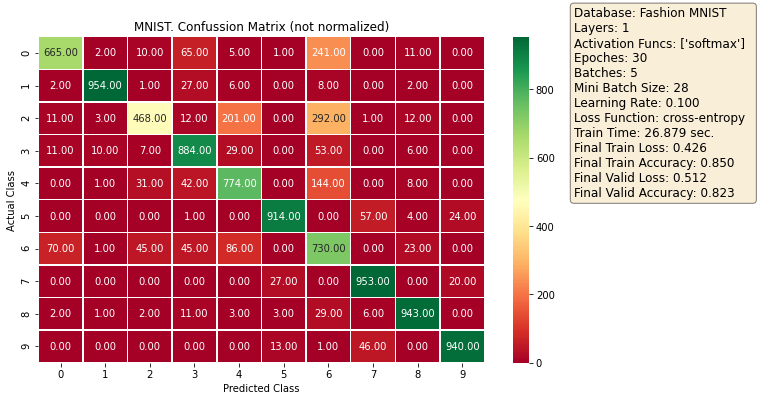

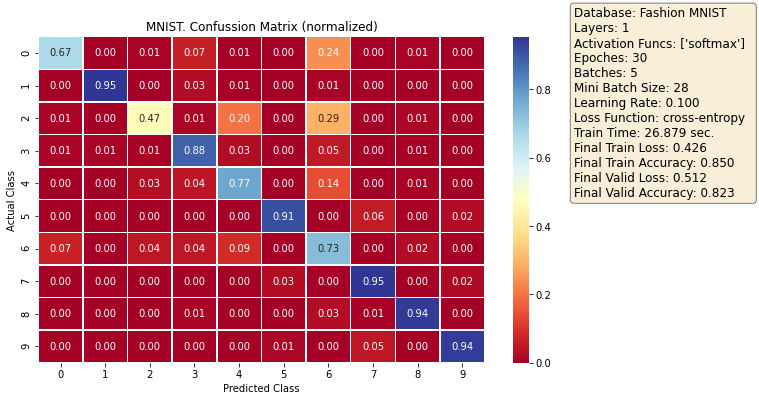

In [54]:
layer1 = NeuralNetworkLayer(784, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.1)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l1'), img_format='_3.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'MNIST', os.path.join(img_dir, 'l1'), ' 3.png', description)

### Применение нейронной сети с 2-мя слоями (с различными гиперпараметрами)

Initial train loss=2.362, accuracy=0.017
Initial valid loss=2.367, accuracy=0.018
Final train loss=0.293, accuracy=0.896
Final valid loss=0.363, accuracy=0.871


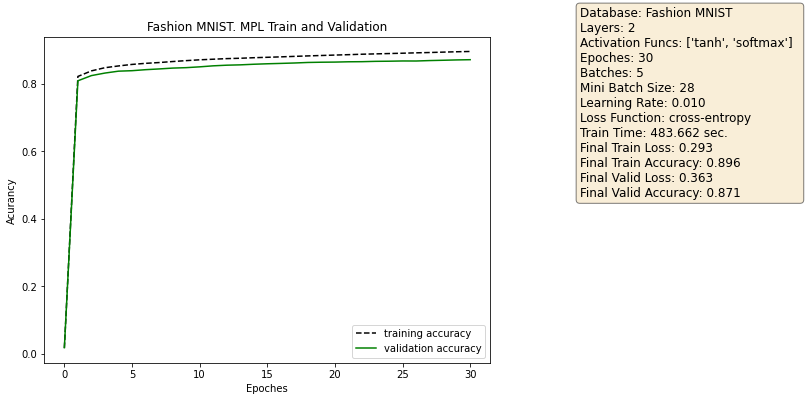

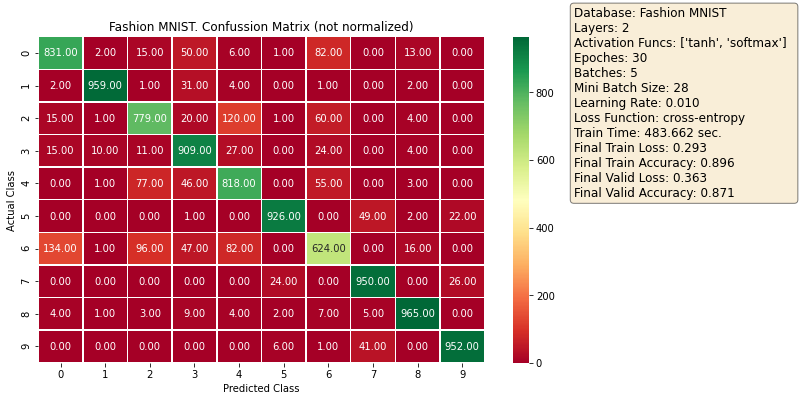

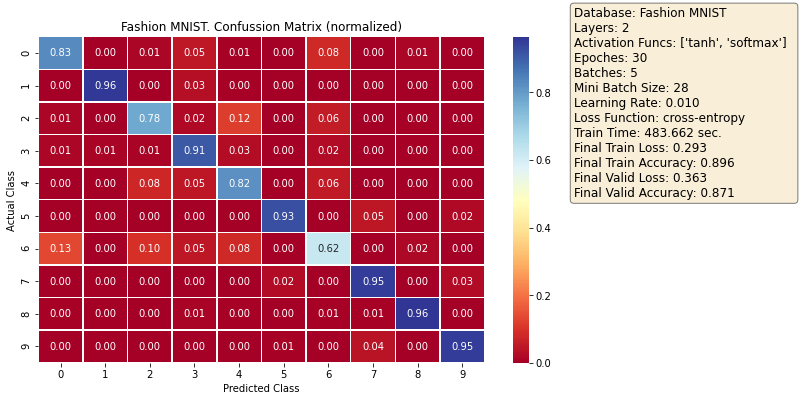

In [55]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l2'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l2'), ' 1.png', description)

Initial train loss=2.360, accuracy=0.096
Initial valid loss=2.359, accuracy=0.094
Final train loss=0.395, accuracy=0.861
Final valid loss=0.435, accuracy=0.843


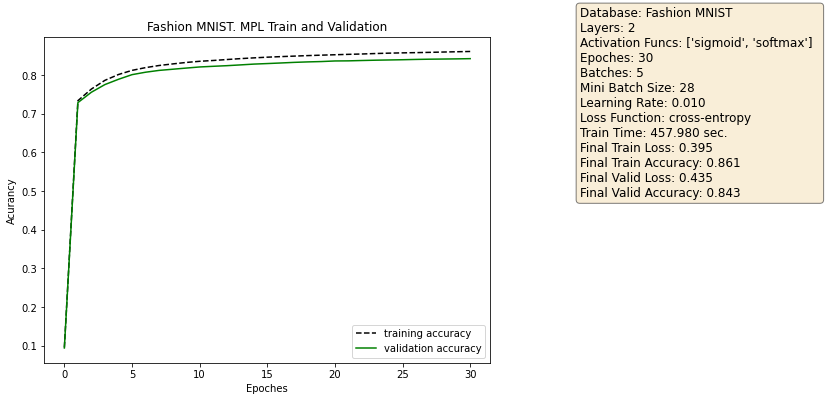

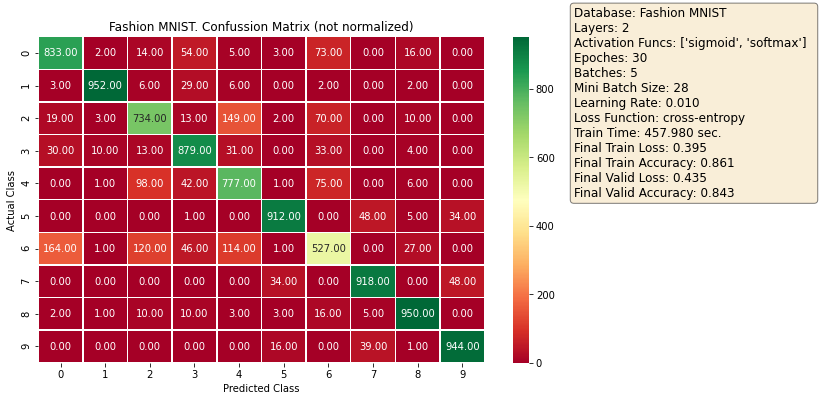

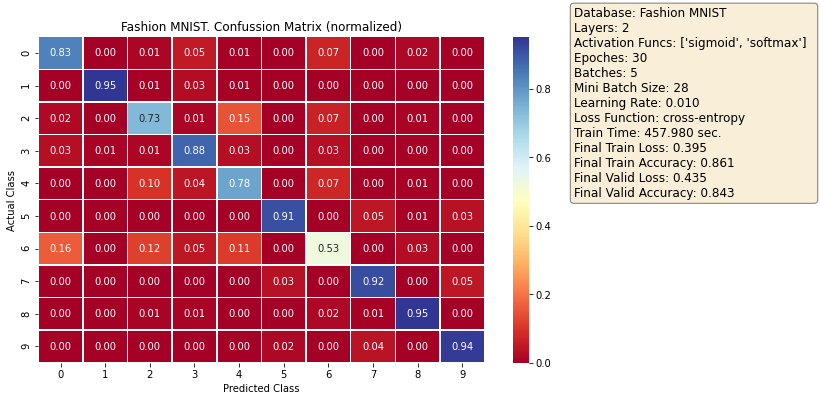

In [56]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('sigmoid'))
layer2 = NeuralNetworkLayer(392, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l2'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l2'), ' 2.png', description)

### Применение нейронной сети с 3-мя слоями (с различными гиперпараметрами)

Initial train loss=2.388, accuracy=0.092
Initial valid loss=2.387, accuracy=0.090
Final train loss=0.320, accuracy=0.885
Final valid loss=0.378, accuracy=0.865


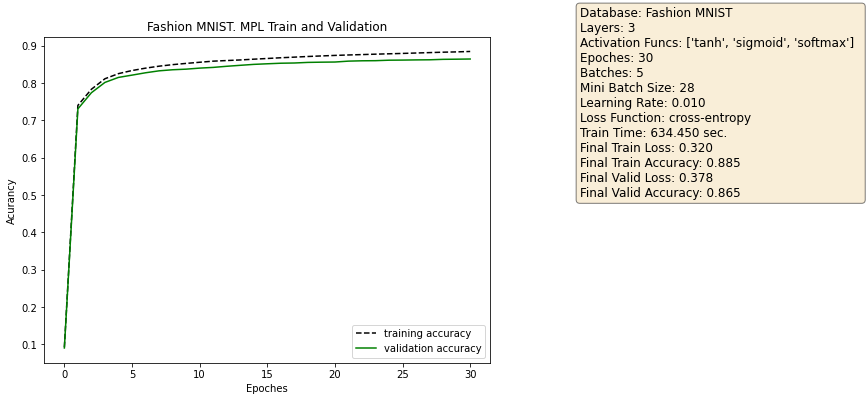

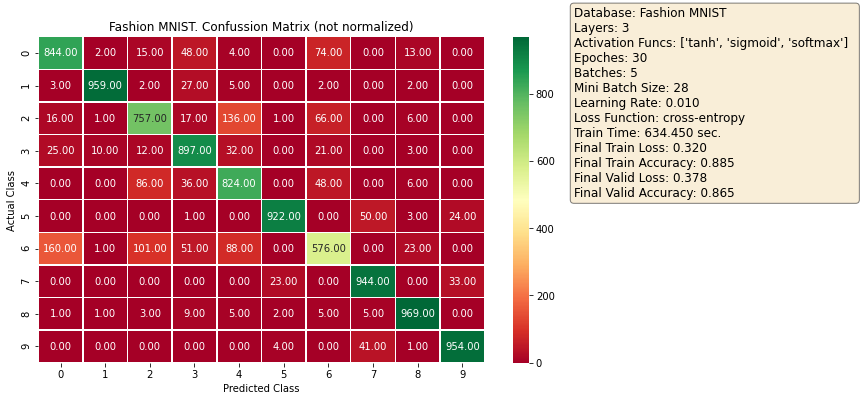

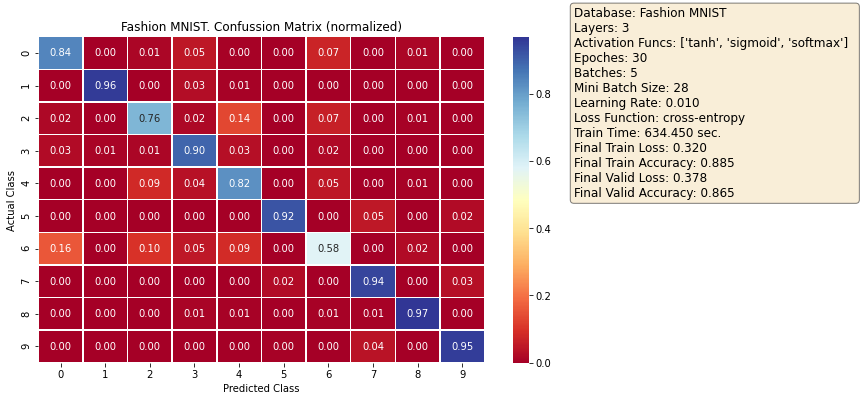

In [57]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('sigmoid'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_1.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l3'), ' 1.png', description)

Initial train loss=2.434, accuracy=0.100
Initial valid loss=2.433, accuracy=0.100
Final train loss=0.322, accuracy=0.884
Final valid loss=0.377, accuracy=0.865


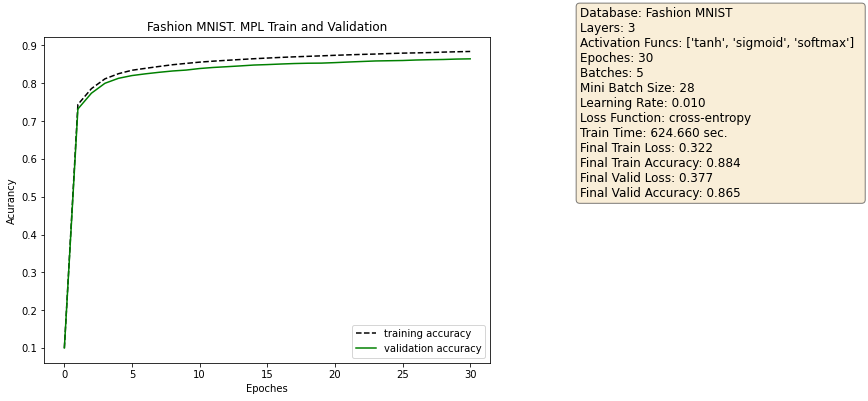

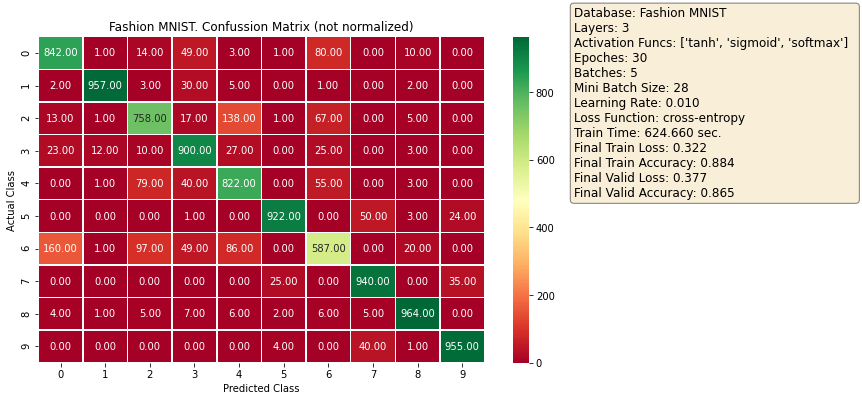

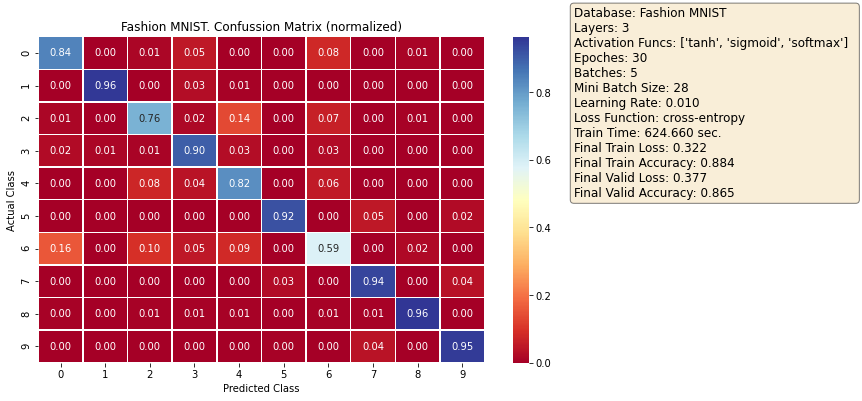

In [58]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('sigmoid'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_2.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l3'), ' 2.png', description)

Initial train loss=2.382, accuracy=0.147
Initial valid loss=2.382, accuracy=0.150
Final train loss=0.256, accuracy=0.907
Final valid loss=0.344, accuracy=0.878


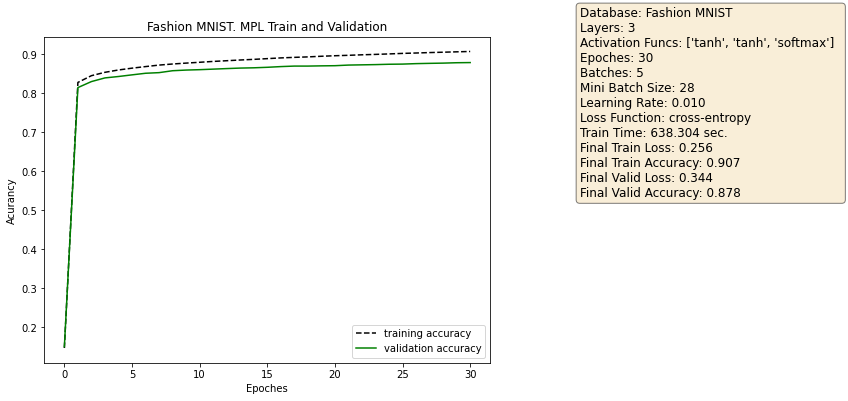

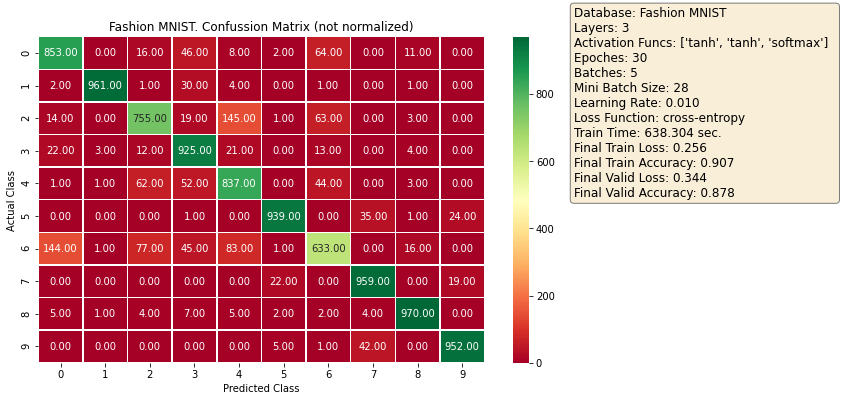

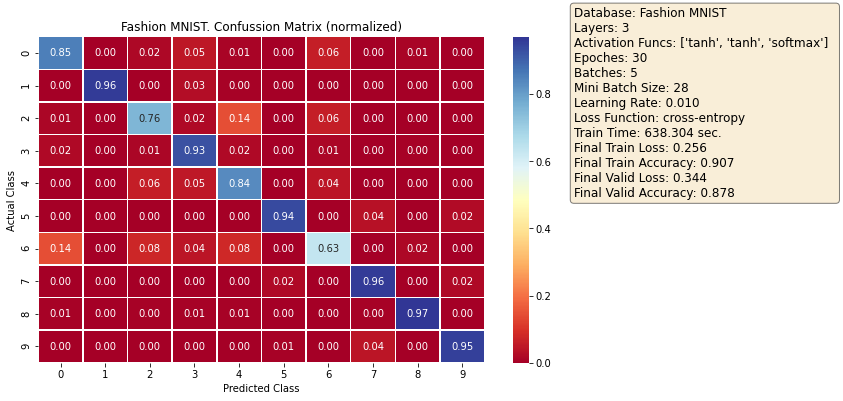

In [59]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('tanh'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('tanh'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_3.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l3'), ' 3.png', description)

Initial train loss=2.463, accuracy=0.100
Initial valid loss=2.463, accuracy=0.100
Final train loss=0.420, accuracy=0.852
Final valid loss=0.458, accuracy=0.837


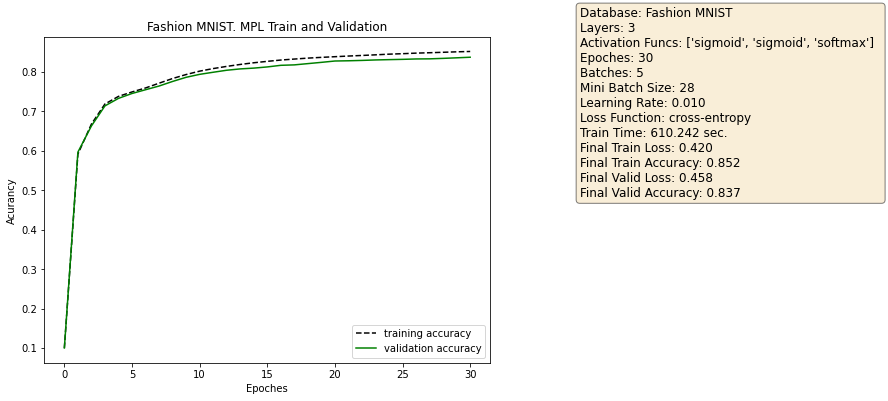

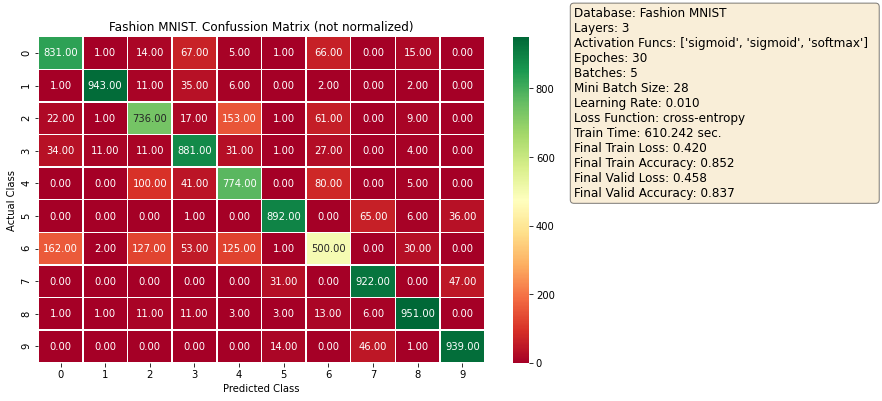

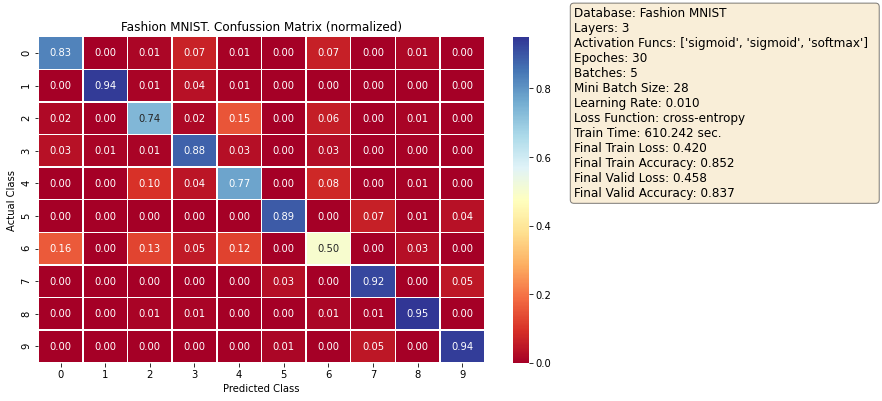

In [60]:
layer1 = NeuralNetworkLayer(784, 392, activation_func=ActivationFunction('sigmoid'))
layer2 = NeuralNetworkLayer(392, 196, activation_func=ActivationFunction('sigmoid'))
layer3 = NeuralNetworkLayer(196, 10, activation_func=ActivationFunction('softmax'))
net = NeuralNetwork([layer1, layer2, layer3])
trainer = NeuralNetworkTrainer(mini_batch_size=28, learning_rate=0.01)
description = train_and_plot(net, x_train, y_train, x_test, y_test, trainer, n_epoch, loss,
               n_batches=5, db_name='Fashion MNIST', img_dir=os.path.join(img_dir, 'l3'), img_format='_4.png')
plot_confusion_matrix(net, x_test, y_test, loss, 5, 'Fashion MNIST', os.path.join(img_dir, 'l3'), ' 4.png', description)

In [62]:
# !zip -r /content/img_fashion-mnist.zip /content/img_fashion-mnist

  adding: content/img_fashion-mnist/ (stored 0%)
  adding: content/img_fashion-mnist/l1/ (stored 0%)
  adding: content/img_fashion-mnist/l1/MNIST. Confussion Matrix (not normalized) 3.png (deflated 3%)
  adding: content/img_fashion-mnist/l1/DS(Fashion MNIST)_NL(1)_E(30)_B(28)_LR(0.1)_LF(cross-entropy)._3.png (deflated 11%)
  adding: content/img_fashion-mnist/l1/DS(Fashion MNIST)_NL(1)_E(30)_B(28)_LR(0.05)_LF(cross-entropy)._2.png (deflated 11%)
  adding: content/img_fashion-mnist/l1/Fashion MNIST. Confussion Matrix (not normalized) 1.png (deflated 3%)
  adding: content/img_fashion-mnist/l1/Fashion MNIST. Confussion Matrix (not normalized) 2.png (deflated 3%)
  adding: content/img_fashion-mnist/l1/DS(Fashion MNIST)_NL(1)_E(30)_B(28)_LR(0.1)_LF(cross-entropy)_3.png (deflated 5%)
  adding: content/img_fashion-mnist/l1/DS(Fashion MNIST)_NL(1)_E(30)_B(28)_LR(0.01)_LF(cross-entropy)_1.png (deflated 5%)
  adding: content/img_fashion-mnist/l1/Fashion MNIST. Confussion Matrix (normalized) 1.png

In [63]:
# from google.colab import files
# files.download("/content/img_fashion-mnist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>